In [6]:
from qbraid_algorithms.qtran import QasmBuilder, std_gates, GateLibrary, GateBuilder
from matplotlib import pyplot as plt
import networkx as nx
# from qbraid.runtime import QbraidProvider
from qbraid_algorithms.qaoa import QAOA
import pyqasm

In [7]:
def qaoa_maxcut(builder : QasmBuilder, graph : nx.Graph) -> tuple[str, str] : 
    std = builder.import_library(lib_class=std_gates)
        
    cost_name = f"qaoa_maxcut_cost_{builder.qubits}"

    qubit_array_param = f"qubit[{builder.qubits}] qubits"

    gamma = "float gamma"

    # cost hamiltonian \sum_{E(graph)} Z_i @ Z_j
    std.begin_subroutine(
        cost_name, [qubit_array_param , gamma]
    )

    for i,j in graph.edges:
        std.cnot(i,j)
        std.rz("2 * gamma", j)
        std.cnot(i,j)

    std.end_subroutine()


    # mixer hamiltonian \sum_{i} X_i
    mixer_name = f"qaoa_maxcut_mixer_{builder.qubits}"

    alpha = "float alpha"

    std.begin_subroutine(
        mixer_name, [qubit_array_param, alpha]
    )

    for i in range(builder.qubits):
        std.rx("-2 * alpha", i)
    
    std.end_subroutine()

    return mixer_name, cost_name

def layer(builder : QasmBuilder, cost_ham : str, mixer_ham : str) -> str :
    std = builder.import_library(lib_class=std_gates)

    name = f"qaoa_layer_function_{builder.qubits}"

    qubit_array_param = f"qubit[{builder.qubits}] qubits"
    gamma = "float gamma"
    alpha = "float alpha"

    std.begin_subroutine(
        name, [qubit_array_param , gamma, alpha]
    )

    std.call_subroutine(cost_ham, ["qubits", "gamma"])
    std.call_subroutine(mixer_ham, ["qubits", "alpha"])

    std.end_subroutine()

    return name

def cost_function(builder : QasmBuilder, layer : str, depth : int, params : list[tuple[float, float]]) -> str :
    std = builder.import_library(lib_class=std_gates)

    name = f"qaoa_cost_function_{layer}"

    qubit_array_param = f"qubit[{builder.qubits}] qubits"

    for i in range(builder.qubits):
        std.h(i)

    for i in range(depth):
        std.call_subroutine(layer, parameters=["qubits", params[i][0], params[i][1]])

    return name


def calculate_gradient_function(builder : QasmBuilder, hamiltonian : str, delta : float = 0.1) -> str :
    std = builder.import_library(lib_class=std_gates)

    name = f"qaoa_compute_gradient_{hamiltonian}"

    qubit_array_param = f"qubit[{builder.qubits}] qubits"

    std.begin_subroutine(
        name, [qubit_array_param, "float value"], "float"
    )
    std.add_var(name="frac", qtype="float")
    std.add_var(name="val1", qtype="int")
    std.add_var(name="val2", qtype="int")
    std.call_subroutine(hamiltonian, [qubit_array_param, f"value + {delta}"])
    std.measure(range(builder.qubits), range(builder.qubits))
    std.classical_op(f"val1 = cb[0:{builder.qubits}]")
    std.call_subroutine(hamiltonian, [qubit_array_param, f"value - {delta}"])
    std.measure(range(builder.qubits), [i + builder.qubits for i in range(builder.qubits)])
    std.classical_op(f"val2 = cb[{builder.qubits}:{builder.qubits*2}]")
    std.classical_op(operation=f"frac = (val1 - val2)/(2* {delta})")

    std.classical_op(operation="return frac")

    std.end_subroutine()

    return name

def generate_algorithm(builder : QasmBuilder, layer : str, cost_ham : str, depth : int, epsilon : float = 0.01) :
    std = builder.import_library(lib_class=std_gates)

    num_qubits = builder.qubits
    builder.claim_qubits(builder.qubits)
    builder.claim_qubits(1)

    repetitions = int(round((1.0/epsilon)**2))
    
    for i in range(depth):
        std.add_input_var(f"gamma_{i}", qtype="float")
        std.add_input_var(f"alpha_{i}", qtype="float")
    
    std.add_var(name="measure_0", qtype="int")
    std.add_output_var("expval", qtype="float")
    std.begin_loop(repetitions)
    
    for q in range(builder.qubits):
        std.reset(q)
    
    for q in range(builder.qubits):
        std.h(q)

    for i in range(depth):
        std.call_subroutine(layer, parameters=[f"qb[0:{num_qubits}]", f"gamma_{i}", f"alpha_{i}"])
        std.call_subroutine(layer, parameters=[f"qb[{num_qubits}:{num_qubits*2}]", f"gamma_{i}", f"alpha_{i}"])

    std.call_subroutine(cost_ham, [f"qb[0:{num_qubits}]", "1"])
    std.h(builder.qubits - 1)
    for q in range(num_qubits):
        std.cswap(control=f"qb[{builder.qubits - 1}]", targ1=f"qb[{q}]", targ2=f"qb[{q+num_qubits}]")
    
    std.measure(f"qb[{builder.qubits - 1}", "cb[0]")

    std.begin_if("cb[0] == 0")
    std.classical_op("measure_0 = measure_0 + 1")
    std.end_if()
    
    std.end_loop()

    std.classical_op(f"expval = measure_0/{repetitions}")
    std.classical_op("expval = 2*(expval - 0.5)")
    std.classical_op("expval = sqrt(expval)")
    std.classical_op("expval = log(expval)")


In [8]:
def expectation_value(builder : QasmBuilder, cost_ham : str, params : list[tuple[float, float]], epsilon : float = 0.01) -> str :
    repetitions = int(Math.round(Math.pow(1/epsilon, 2)))
    std = builder.import_library(lib_class=std_gates)
    original_qubits = builder.qubits
    builder.claim_qubits(builder.qubits)

    name = f"qaoa_compute_expectation_value_{cost_ham}"

    qubit_copy_array_param = f"qubit[{original_qubits}] qubits_copy"

    std.begin_subroutine(
        name, [qubit_copy_array_param], "float"
    )

    for i in range(repetitions):
        std.call_subroutine(cost_ham, ["qubits_copy", "1"])


In [9]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)
algo = QAOA(3)
algo.setup_maxcut(graph=graph)
module = algo.generate_algorithm(algo.cost_hamiltonian, 2)
'''mixer_name, cost_name = qaoa_maxcut(builder=builder, graph=graph)
print(mixer_name)
print(cost_name)
layer_name = layer(builder=builder, cost_ham=cost_name, mixer_ham=mixer_name)
print(cost_function(builder=builder, depth=2, layer=layer_name, params=[[0.5, 0.5], [0.5, 0.5]]))

generate_algorithm(builder=builder, layer=layer_name, cost_ham=cost_name, depth=2)'''

stdgates: subroutine qaoa_maxcut_cost_3 is not part of visible scope, make sure that this isn't a floating reference / malformed statement, or is at least previously defined within untracked environment definitions
stdgates: subroutine qaoa_x_mixer_3 is not part of visible scope, make sure that this isn't a floating reference / malformed statement, or is at least previously defined within untracked environment definitions
stdgates: subroutine qaoa_layer_function_3 is not part of visible scope, make sure that this isn't a floating reference / malformed statement, or is at least previously defined within untracked environment definitions
stdgates: subroutine qaoa_layer_function_3 is not part of visible scope, make sure that this isn't a floating reference / malformed statement, or is at least previously defined within untracked environment definitions
stdgates: subroutine qaoa_layer_function_3 is not part of visible scope, make sure that this isn't a floating reference / malformed statem

'mixer_name, cost_name = qaoa_maxcut(builder=builder, graph=graph)\nprint(mixer_name)\nprint(cost_name)\nlayer_name = layer(builder=builder, cost_ham=cost_name, mixer_ham=mixer_name)\nprint(cost_function(builder=builder, depth=2, layer=layer_name, params=[[0.5, 0.5], [0.5, 0.5]]))\n\ngenerate_algorithm(builder=builder, layer=layer_name, cost_ham=cost_name, depth=2)'

In [10]:
program = module

print(program)

module = pyqasm.loads(program)

OPENQASM 3;
include "stdgates.inc";
qubit[7] qb;
bit[6] cb;
def qaoa_maxcut_cost_3(qubit[3] qubits,float gamma) {
	cnot qb[0],qb[1];
	rz(2 * gamma) qb[1];
	cnot qb[0],qb[1];
	cnot qb[0],qb[2];
	rz(2 * gamma) qb[2];
	cnot qb[0],qb[2];
	cnot qb[1],qb[2];
	rz(2 * gamma) qb[2];
	cnot qb[1],qb[2];
	cnot qb[2],qb[3];
	rz(2 * gamma) qb[3];
	cnot qb[2],qb[3];
}
def qaoa_x_mixer_3(qubit[3] qubits,float alpha) {
	rx(-2 * alpha) qb[0];
	rx(-2 * alpha) qb[1];
	rx(-2 * alpha) qb[2];
}
def qaoa_layer_function_3(qubit[3] qubits,float gamma,float alpha) {
	qaoa_maxcut_cost_3(qubits, gamma);
	qaoa_x_mixer_3(qubits, alpha);
}
input float gamma_0;
input float alpha_0;
input float gamma_1;
input float alpha_1;
int measure_0;
output float expval;
for int i in [0:9999] {
	reset qb[0];
	reset qb[1];
	reset qb[2];
	reset qb[3];
	reset qb[4];
	reset qb[5];
	reset qb[6];
	h qb[0];
	h qb[1];
	h qb[2];
	h qb[3];
	h qb[4];
	h qb[5];
	h qb[6];
	qaoa_layer_function_3(qb[0:3], gamma_0, alpha_0);
	qaoa_layer_function_

In [31]:
import pennylane as qml
from qiskit_qasm3_import import parse
from qiskit import qasm3

In [36]:
program = """
OPENQASM 3;
include "stdgates.inc";
input float gamma_0;
input float alpha_0;
input float gamma_1;
input float alpha_1;
qubit[7] qb;
bit[3] mid;
def qaoa_maxcut_cost_3(qubit[3] qubits,float gamma) {
	cnot qb[0],qb[1];
	rz(2 * gamma) qb[1];
	cnot qb[0],qb[1];
	cnot qb[0],qb[2];
	rz(2 * gamma) qb[2];
	cnot qb[0],qb[2];
	cnot qb[1],qb[2];
	rz(2 * gamma) qb[2];
	cnot qb[1],qb[2];
	cnot qb[2],qb[3];
	rz(2 * gamma) qb[3];
	cnot qb[2],qb[3];
}
def qaoa_x_mixer_3(qubit[3] qubits,float alpha) {
	rx(-2 * alpha) qb[0];
	rx(-2 * alpha) qb[1];
	rx(-2 * alpha) qb[2];
}
def qaoa_layer_function_3(qubit[3] qubits,float gamma,float alpha) {
	qaoa_maxcut_cost_3(qubits, gamma);
	qaoa_x_mixer_3(qubits, alpha);
}
for int i in [0:9999] {
	reset qb[0];
	reset qb[1];
	reset qb[2];
	reset qb[3];
	reset qb[4];
	reset qb[5];
	reset qb[6];
	h qb[0];
	h qb[1];
	h qb[2];
	h qb[3];
	h qb[4];
	h qb[5];
	h qb[6];
	qaoa_layer_function_3(qb[0:3], gamma_0, alpha_0);
	qaoa_layer_function_3(qb[3:6], gamma_0, alpha_0);
	qaoa_layer_function_3(qb[0:3], gamma_1, alpha_1);
	qaoa_layer_function_3(qb[3:6], gamma_1, alpha_1);
	qaoa_maxcut_cost_3(qb[0:3], 1);
	h qb[6];
	cswap qb[qb[6]],qb[qb[0], qb[3]];
	cswap qb[qb[6]],qb[qb[1], qb[4]];
	cswap qb[qb[6]],qb[qb[2], qb[5]];
	measure qb[{6}] -> mid[0];
	if (mid[0] == 0){
		measure_0 = measure_0 + 1;
	}
}
out = measure_0/10000;
out = 2*(out - 0.5);
out = sqrt(out);
out = log(out);

"""


module = pyqasm.loads(program)
#loaded_circuit = qml.from_qasm(module.unroll())
print(module.unroll())

ERROR:pyqasm: Error at line 48, column 1 in QASM file

 >>>>>> qaoa_layer_function_3(qb[0:3], gamma_0, alpha_0)



ValidationError: Undefined variable 'gamma_0' used for function call 'qaoa_layer_function_3'

Usage: qaoa_layer_function_3 ( qubit[3] qubits , float gamma , float alpha )


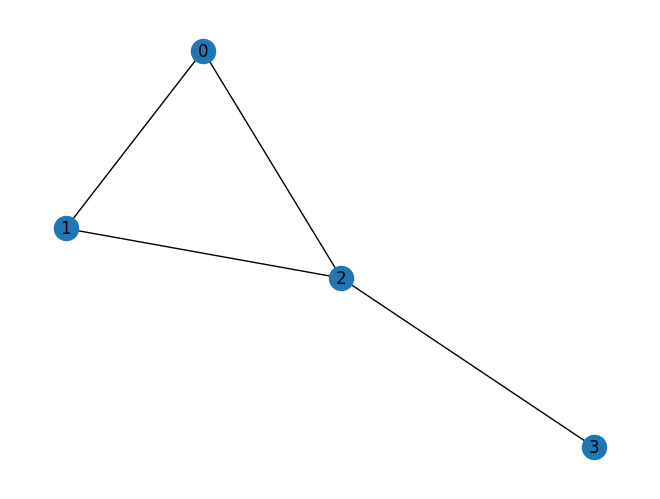

In [ ]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)

nx.draw(graph, with_labels=True, pos=positions)
plt.show()

In [ ]:
for i,j in graph.edges:
    std.cnot(i,j)
    std.rz(2, j)
    std.cnot(i,j)

In [ ]:
program = builder.build()
print(program)

OPENQASM 3;
include "stdgates.inc";
qubit[3] qb;
bit[3] cb;
def qaoa_cost_3(qubit[3] qubits) {
	z qb[0];
	z qb[1];
	z qb[2];
}
cnot qb[0],qb[1];
rz(2) qb[1];
cnot qb[0],qb[1];
cnot qb[0],qb[2];
rz(2) qb[2];
cnot qb[0],qb[2];
cnot qb[1],qb[2];
rz(2) qb[2];
cnot qb[1],qb[2];
cnot qb[2],qb[3];
rz(2) qb[3];
cnot qb[2],qb[3];

